✅ Using device: cuda
🚀 Starting Training...

Epoch 01: Train Loss = 0.092748 | Val Loss = 0.000130
Epoch 02: Train Loss = 0.000102 | Val Loss = 0.000117
Epoch 03: Train Loss = 0.000092 | Val Loss = 0.000107
Epoch 04: Train Loss = 0.000081 | Val Loss = 0.000090
Epoch 05: Train Loss = 0.000069 | Val Loss = 0.000081
Epoch 06: Train Loss = 0.000058 | Val Loss = 0.000063
Epoch 07: Train Loss = 0.000048 | Val Loss = 0.000051
Epoch 08: Train Loss = 0.000038 | Val Loss = 0.000044
Epoch 09: Train Loss = 0.000031 | Val Loss = 0.000032
Epoch 10: Train Loss = 0.000025 | Val Loss = 0.000026
Epoch 11: Train Loss = 0.000021 | Val Loss = 0.000021
Epoch 12: Train Loss = 0.000017 | Val Loss = 0.000016
Epoch 13: Train Loss = 0.000013 | Val Loss = 0.000013
Epoch 14: Train Loss = 0.000010 | Val Loss = 0.000010
Epoch 15: Train Loss = 0.000009 | Val Loss = 0.000008
Epoch 16: Train Loss = 0.000006 | Val Loss = 0.000006
Epoch 17: Train Loss = 0.000005 | Val Loss = 0.000005
Epoch 18: Train Loss = 0.000005 | Val

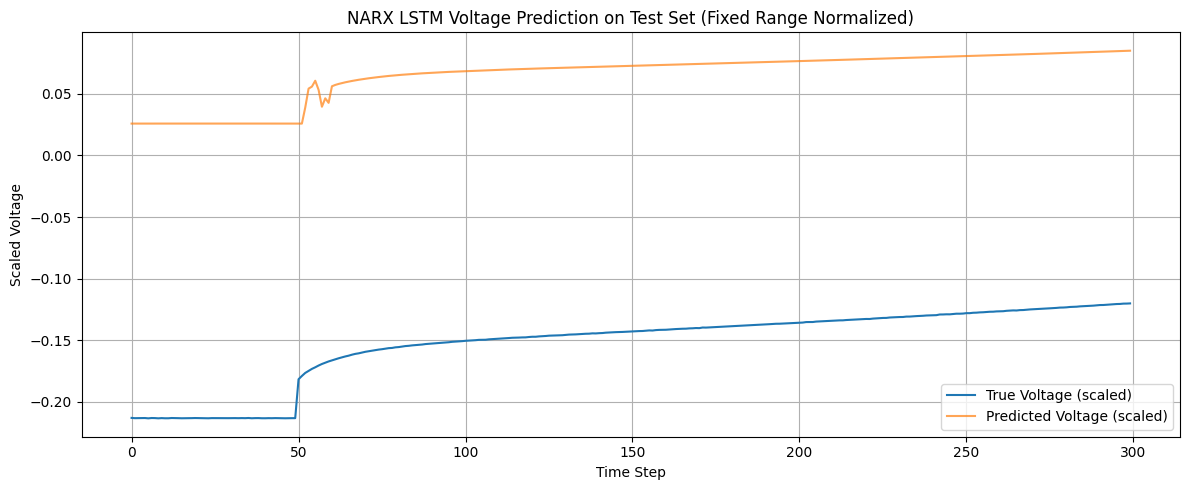

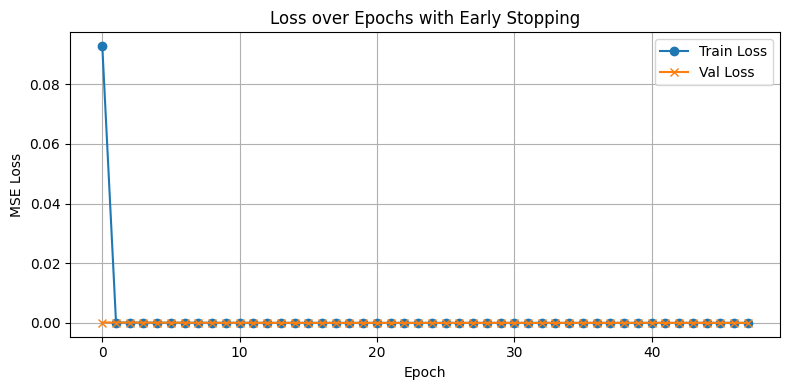

In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time
import gc
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ------------------- DEVICE SETUP -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ------------------- LOAD TRAINING DATA -------------------
df = pd.read_csv("/content/Combined_train_Data.csv").iloc[:5000]
I = -df['Current_A'].values.reshape(-1, 1)  # Inverted current
V = df['Voltage_V'].values.reshape(-1, 1)

# ------------------- FIXED RANGE NORMALIZATION -------------------
scaler_I = MinMaxScaler()
scaler_V = MinMaxScaler(feature_range=(-1, 1))
scaler_I.fit(I)
scaler_V.fit([[2.5], [4.3]])  # fixed voltage range

I_scaled = scaler_I.transform(I)
V_scaled = scaler_V.transform(V)

# ------------------- NARX SEQUENCE CREATION -------------------
def create_narx_sequences(I_seq, V_seq, n_current_delays, n_voltage_delays):
    X, y = [], []
    max_delay = max(n_current_delays, n_voltage_delays)
    for i in range(max_delay, len(I_seq) - 1):
        input_i = []
        input_i.extend(I_seq[i - n_current_delays:i, 0])
        input_i.extend(V_seq[i - n_voltage_delays:i, 0])
        X.append(input_i)
        y.append(V_seq[i + 1])  # predict next-step voltage
    return np.array(X), np.array(y)

n_current_delays = 10
n_voltage_delays = 10
input_dim = n_current_delays + n_voltage_delays

X, y = create_narx_sequences(I_scaled, V_scaled, n_current_delays, n_voltage_delays)
X = X.reshape((X.shape[0], 1, input_dim))

# ------------------- MODEL DEFINITION -------------------
class NARXLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(NARXLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# ------------------- DATA LOADERS -------------------
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# ------------------- TRAINING WITH EARLY STOPPING -------------------
model = NARXLSTM(input_dim=input_dim, hidden_dim=128, num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

patience = 5
best_val_loss = float('inf')
counter = 0
train_losses = []
val_losses = []
best_model_state = None

print("🚀 Starting Training...\n")
for epoch in range(50):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_loss += criterion(pred, yb).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1:02d}: Train Loss = {epoch_loss:.6f} | Val Loss = {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping triggered!")
            break

    gc.collect()
    torch.cuda.empty_cache()

# ------------------- RESTORE BEST MODEL -------------------
model.load_state_dict(best_model_state)

# ------------------- LOAD TEST DATA -------------------
test_df = pd.read_excel("/content/Merged_test_Data.xlsx", engine="openpyxl")
current_test = -test_df['Current_A'].values.reshape(-1, 1)
voltage_test = test_df['Voltage_V'].values.reshape(-1, 1)

current_test_scaled = scaler_I.transform(current_test)
voltage_test_scaled = scaler_V.transform(voltage_test)

X_test, y_test = create_narx_sequences(current_test_scaled, voltage_test_scaled,
                                       n_current_delays, n_voltage_delays)
X_test = X_test.reshape((X_test.shape[0], 1, input_dim))

X_test_tensor = torch.tensor(X_test[:5000], dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test[:5000], dtype=torch.float32).to(device)

# ------------------- TEST EVALUATION -------------------
print("🔍 Running test evaluation...")
model.eval()
with torch.no_grad():
    pred_scaled = model(X_test_tensor).cpu().numpy()
    true_scaled = y_test_tensor.cpu().numpy()

rmse = np.sqrt(mean_squared_error(true_scaled, pred_scaled))
mae = mean_absolute_error(true_scaled, pred_scaled)
r2 = r2_score(true_scaled, pred_scaled)

print("\n📊 Test Set Evaluation (Normalized Scale):")
print(f"RMSE: {rmse:.6f}")
print(f"MAE : {mae:.6f}")
print(f"R²  : {r2:.6f}")

# ------------------- PLOT PREDICTIONS -------------------
plt.figure(figsize=(12, 5))
plt.plot(true_scaled[:300], label='True Voltage (scaled)')
plt.plot(pred_scaled[:300], label='Predicted Voltage (scaled)', alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Scaled Voltage")
plt.title("NARX LSTM Voltage Prediction on Test Set (Fixed Range Normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------- PLOT LOSS CURVES -------------------
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='x')
plt.title("Loss over Epochs with Early Stopping")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Using device: cuda
🚀 Starting Training...

Epoch 01: Train Loss = 0.000200 | Val Loss = 0.000002
Epoch 02: Train Loss = 0.000000 | Val Loss = 0.000002
Epoch 03: Train Loss = 0.000000 | Val Loss = 0.000002
Epoch 04: Train Loss = 0.000000 | Val Loss = 0.000002
Epoch 05: Train Loss = 0.000000 | Val Loss = 0.000002
Epoch 06: Train Loss = 0.000000 | Val Loss = 0.000002
Epoch 07: Train Loss = 0.000000 | Val Loss = 0.000002
Epoch 08: Train Loss = 0.000000 | Val Loss = 0.000002
Epoch 09: Train Loss = 0.000000 | Val Loss = 0.000002
Epoch 10: Train Loss = 0.000000 | Val Loss = 0.000002
Epoch 11: Train Loss = 0.000000 | Val Loss = 0.000002
Epoch 12: Train Loss = 0.000000 | Val Loss = 0.000002
Epoch 13: Train Loss = 0.000000 | Val Loss = 0.000002
Epoch 14: Train Loss = 0.000000 | Val Loss = 0.000002
Epoch 15: Train Loss = 0.000000 | Val Loss = 0.000002
Epoch 16: Train Loss = 0.000000 | Val Loss = 0.000002
Epoch 17: Train Loss = 0.000000 | Val Loss = 0.000002
Epoch 18: Train Loss = 0.000000 | Val

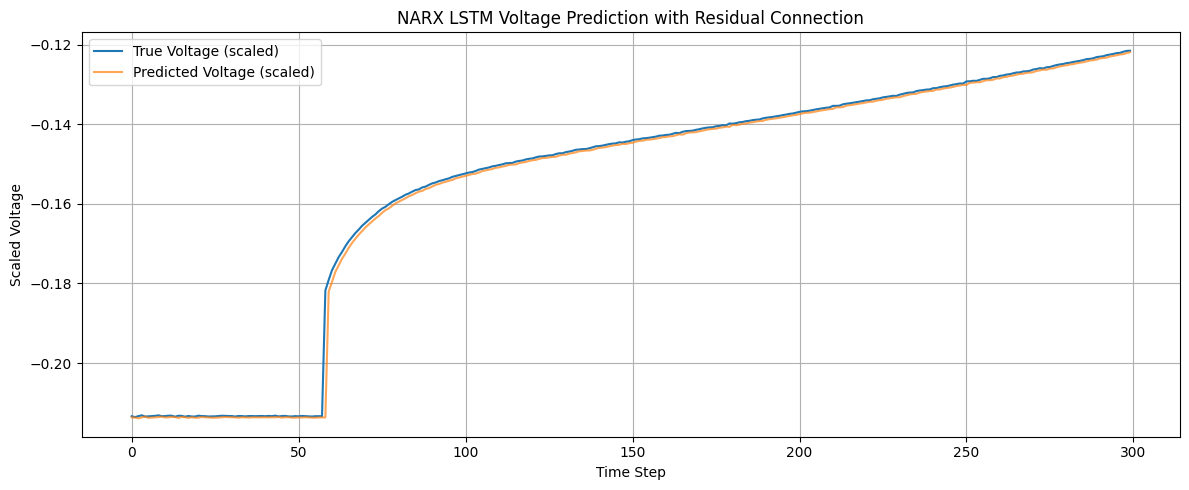

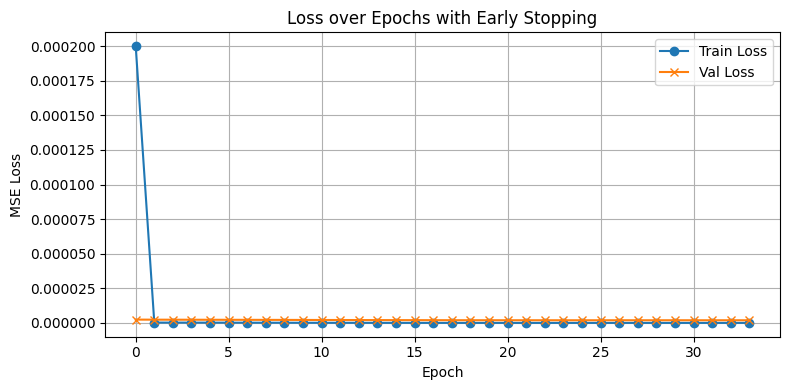

In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time
import gc
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ------------------- DEVICE SETUP -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ------------------- LOAD TRAINING DATA -------------------
df = pd.read_csv("/content/Combined_train_Data.csv").iloc[:5000]
I = -df['Current_A'].values.reshape(-1, 1)  # Invert current
V = df['Voltage_V'].values.reshape(-1, 1)

# ------------------- FIXED RANGE NORMALIZATION -------------------
scaler_I = MinMaxScaler()
scaler_V = MinMaxScaler(feature_range=(-1, 1))
scaler_I.fit(I)
scaler_V.fit([[2.5], [4.3]])

I_scaled = scaler_I.transform(I)
V_scaled = scaler_V.transform(V)

# ------------------- NARX SEQUENCE WITH RESIDUAL V(t-1) -------------------
def create_narx_sequences(I_seq, V_seq, n_current_delays, n_voltage_delays):
    X, y, v_tm1 = [], [], []
    max_delay = max(n_current_delays, n_voltage_delays)
    for i in range(max_delay, len(I_seq) - 1):
        input_i = []
        input_i.extend(I_seq[i - n_current_delays:i, 0])
        input_i.extend(V_seq[i - n_voltage_delays:i, 0])
        X.append(input_i)
        y.append(V_seq[i + 1])       # true voltage at t
        v_tm1.append(V_seq[i])       # residual V(t-1)
    return np.array(X), np.array(y), np.array(v_tm1)

n_current_delays = 1
n_voltage_delays = 2
input_dim = n_current_delays + n_voltage_delays

X, y, V_tm1 = create_narx_sequences(I_scaled, V_scaled, n_current_delays, n_voltage_delays)
X = X.reshape((X.shape[0], 1, input_dim))
V_tm1 = V_tm1.reshape(-1, 1)

# ------------------- MODEL WITH RESIDUAL CONNECTION -------------------
class ResidualNARXLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(ResidualNARXLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, v_tm1):
        out, _ = self.lstm(x)
        residual_pred = self.fc(out[:, -1, :])
        return residual_pred + v_tm1  # Residual: output + V(t-1)

# ------------------- DATA LOADERS -------------------
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
V_tm1_tensor = torch.tensor(V_tm1, dtype=torch.float32)

dataset = TensorDataset(X_tensor, V_tm1_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# ------------------- TRAINING WITH EARLY STOPPING -------------------
model = ResidualNARXLSTM(input_dim=input_dim, hidden_dim=64, num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

patience = 5
best_val_loss = float('inf')
counter = 0
train_losses = []
val_losses = []
best_model_state = None

print("🚀 Starting Training...\n")
for epoch in range(50):
    model.train()
    epoch_loss = 0.0
    for xb, v_tm1b, yb in train_loader:
        xb, v_tm1b, yb = xb.to(device), v_tm1b.to(device), yb.to(device)
        pred = model(xb, v_tm1b)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, v_tm1b, yb in val_loader:
            xb, v_tm1b, yb = xb.to(device), v_tm1b.to(device), yb.to(device)
            pred = model(xb, v_tm1b)
            val_loss += criterion(pred, yb).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1:02d}: Train Loss = {epoch_loss:.6f} | Val Loss = {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping triggered!")
            break

    gc.collect()
    torch.cuda.empty_cache()

# ------------------- RESTORE BEST MODEL -------------------
model.load_state_dict(best_model_state)



🔍 Running test evaluation...

📊 Test Set Evaluation (Normalized Scale):
RMSE: 0.007309
MAE : 0.002366
R²  : 0.997154


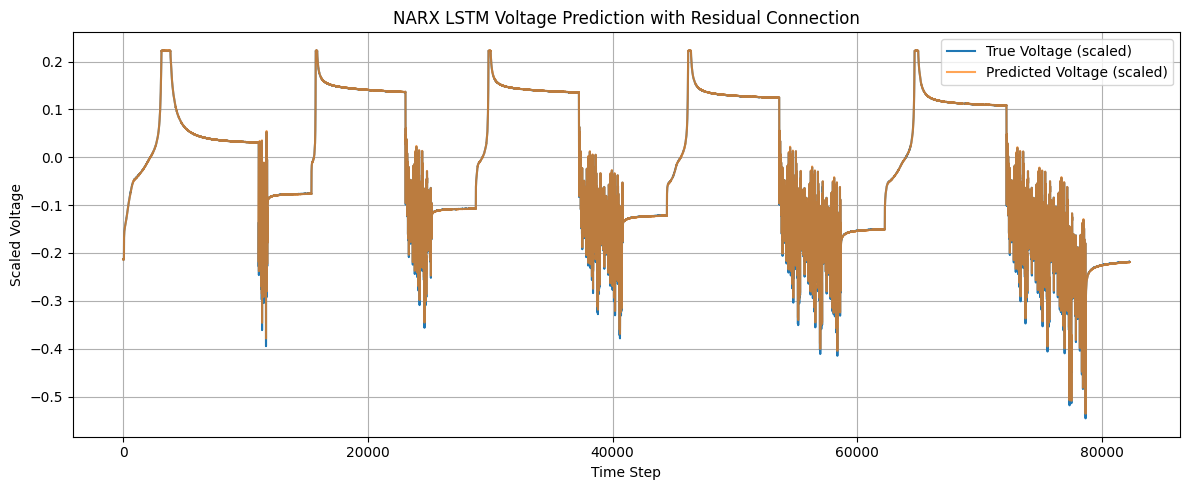

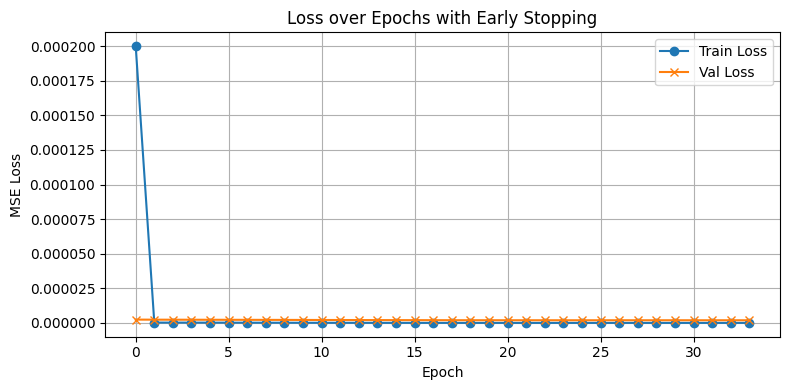

In [21]:
# ------------------- LOAD TEST DATA -------------------
test_df = pd.read_excel("/content/Merged_test_Data.xlsx", engine="openpyxl")
current_test = -test_df['Current_A'].values.reshape(-1, 1)
voltage_test = test_df['Voltage_V'].values.reshape(-1, 1)

current_test_scaled = scaler_I.transform(current_test)
voltage_test_scaled = scaler_V.transform(voltage_test)

X_test, y_test, V_tm1_test = create_narx_sequences(current_test_scaled, voltage_test_scaled,
                                                   n_current_delays, n_voltage_delays)
X_test = X_test.reshape((X_test.shape[0], 1, input_dim))
V_tm1_test = V_tm1_test.reshape(-1, 1)

X_test_tensor = torch.tensor(X_test[:], dtype=torch.float32).to(device)
V_tm1_tensor = torch.tensor(V_tm1_test[:], dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test[:], dtype=torch.float32).to(device)

# ------------------- TEST EVALUATION -------------------
print("🔍 Running test evaluation...")
model.eval()
with torch.no_grad():
    pred_scaled = model(X_test_tensor, V_tm1_tensor).cpu().numpy()
    true_scaled = y_test_tensor.cpu().numpy()

rmse = np.sqrt(mean_squared_error(true_scaled, pred_scaled))
mae = mean_absolute_error(true_scaled, pred_scaled)
r2 = r2_score(true_scaled, pred_scaled)

print("\n📊 Test Set Evaluation (Normalized Scale):")
print(f"RMSE: {rmse:.6f}")
print(f"MAE : {mae:.6f}")
print(f"R²  : {r2:.6f}")

# ------------------- PLOT PREDICTIONS -------------------
plt.figure(figsize=(12, 5))
plt.plot(true_scaled[:], label='True Voltage (scaled)')
plt.plot(pred_scaled[:], label='Predicted Voltage (scaled)', alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Scaled Voltage")
plt.title("NARX LSTM Voltage Prediction with Residual Connection")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------- PLOT LOSS CURVES -------------------
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='x')
plt.title("Loss over Epochs with Early Stopping")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
